## Step 1: Imports and Setup

In [1]:
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 49.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import random
import re
from faker import Faker
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
# Initialization
fake = Faker()
np.random.seed(42)
random.seed(42)

## Step 2: Generate Synthetic Dataset

| Column Name         | Description                                            |
| ------------------- | ------------------------------------------------------ |
| `CustomerID`        | Unique customer identifier (C001, C002, etc.)          |
| `TransactionDate`   | Date of purchase                                       |
| `ProductID`         | Purchased product identifier                           |
| `ProductCategory`   | Product type/category                                  |
| `OriginalPrice`     | Original product price                                 |
| `DiscountPercent`   | % discount applied (0 to 100%)                         |
| `FinalPrice`        | Price after applying discount                          |
| `PurchaseIntent`    | Whether customer actually wanted the item (`Yes`/`No`) |
| `FeedbackComment`   | Customer feedback (text) — for NLP                     |
| `SatisfactionScore` | Satisfaction score (1 to 5)                            |
| `MarketingScheme`   | Real-world scheme type (e.g. "Buy 2 Get 1", "Coupon") |
| `HiddenCondition`   | The fine print (e.g. "Minimum \$50 order")            |


In [4]:
n_samples = 500
product_categories = ['Clothing', 'Electronics', 'Groceries', 'Home Decor']
products = {
    'Clothing': ['Shirt', 'Pants', 'Shoes'],
    'Electronics': ['Phone', 'Laptop', 'Earbuds'],
    'Groceries': ['Cereal', 'Juice', 'Snacks'],
    'Home Decor': ['Lamp', 'Candle', 'Rug']
}
scheme_pool = {
    "Flat % Off": "Minimum order $50",
    "Buy 2 Get 1": "Free item must be cheaper",
    "Spend More Save More": "10% only above $100",
    "Combo Offer": "No item exchange allowed",
    "Limited Time Deal": "Ends in 2 hours",
    "Coupon Code Required": "Use SAVE10 at checkout",
    "Category-Only Discount": "Applies to selected category only",
    "First-Time Buyer Only": "Account must be new"
}
scheme_names = list(scheme_pool.keys())

data = []
for _ in range(n_samples):
    cust_id = f'C{random.randint(1, 50):03}'
    date = fake.date_between(start_date='-6m', end_date='today')
    category = random.choice(product_categories)
    product = random.choice(products[category])
    scheme = random.choice(scheme_names)
    hidden = scheme_pool[scheme]

    if scheme == "Flat % Off":
        discount = random.choice([10, 15, 20, 25])
    elif scheme == "Buy 2 Get 1":
        discount = 33
    elif scheme == "Spend More Save More":
        discount = random.choice([5, 10, 15])
    elif scheme == "Limited Time Deal":
        discount = random.choice([20, 30])
    else:
        discount = random.choice([0, 10, 15, 20])

    price = round(np.random.uniform(10, 500), 2)
    final_price = round(price * (1 - discount / 100), 2)
    feedback_options = [
        "Loved the offer", "Great deal!", "Didn't need this", "Useless offer", "Would buy again",
        "Tricked by discount", "Too good to be true", "Misleading terms", "Happy with purchase"
    ]
    feedback = random.choices(feedback_options, weights=[3, 3, 2, 2, 3, 2, 1, 2, 3])[0]
    intent = "Yes" if feedback in ["Loved the offer", "Great deal!", "Would buy again", "Happy with purchase"] else "No"
    score = round(np.random.normal(4.0, 1.0), 1) if intent == "Yes" else round(np.random.normal(2.0, 1.0), 1)
    score = max(0.0, min(5.0, score))

    data.append([
        cust_id, date, product, category, price, discount, final_price, intent, feedback,
        score, scheme, hidden
    ])

df = pd.DataFrame(data, columns=[
    'CustomerID', 'TransactionDate', 'ProductID', 'ProductCategory', 'OriginalPrice',
    'DiscountPercent', 'FinalPrice', 'PurchaseIntent', 'FeedbackComment',
    'SatisfactionScore', 'MarketingScheme', 'HiddenCondition'
])

In [5]:
df.sample(10)

,CustomerID,TransactionDate,ProductID,ProductCategory,OriginalPrice,DiscountPercent,FinalPrice,PurchaseIntent,FeedbackComment,SatisfactionScore,MarketingScheme,HiddenCondition
190,C024,2025-06-29,Cereal,Groceries,493.14,15,419.17,Yes,Great deal!,3.3,Category-Only Discount,Applies to selected category only
230,C020,2025-06-29,Cereal,Groceries,264.95,10,238.45,Yes,Loved the offer,4.1,Coupon Code Required,Use SAVE10 at checkout
82,C045,2025-06-29,Lamp,Home Decor,410.44,0,410.44,No,Useless offer,3.4,Combo Offer,No item exchange allowed
303,C041,2025-06-29,Cereal,Groceries,343.94,20,275.15,Yes,Would buy again,4.8,Limited Time Deal,Ends in 2 hours
390,C036,2025-06-29,Juice,Groceries,299.24,20,239.39,Yes,Would buy again,4.8,Category-Only Discount,Applies to selected category only
35,C042,2025-06-29,Shirt,Clothing,322.40,15,274.04,No,Misleading terms,1.1,Category-Only Discount,Applies to selected category only
378,C019,2025-06-29,Earbuds,Electronics,123.23,15,104.75,Yes,Great deal!,4.1,Coupon Code Required,Use SAVE10 at checkout
298,C005,2025-06-29,Juice,Groceries,151.43,20,121.14,No,Misleading terms,0.9,First-Time Buyer Only,Account must be new
179,C017,2025-06-29,Candle,Home Decor,378.66,0,378.66,No,Useless offer,0.8,Coupon Code Required,Use SAVE10 at checkout
341,C040,2025-06-29,Phone,Electronics,462.02,15,392.72,No,Tricked by discount,2.6,Flat % Off,Minimum order $50


In [6]:
# Save it
df.to_csv("synthetic_discount_data.csv", index=False)

## Step 3: Preprocessing

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         500 non-null    object 
 1   TransactionDate    500 non-null    object 
 2   ProductID          500 non-null    object 
 3   ProductCategory    500 non-null    object 
 4   OriginalPrice      500 non-null    float64
 5   DiscountPercent    500 non-null    int64  
 6   FinalPrice         500 non-null    float64
 7   PurchaseIntent     500 non-null    object 
 8   FeedbackComment    500 non-null    object 
 9   SatisfactionScore  500 non-null    float64
 10  MarketingScheme    500 non-null    object 
 11  HiddenCondition    500 non-null    object 
dtypes: float64(3), int64(1), object(8)
memory usage: 47.0+ KB


In [8]:
# Make sure date is datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df["CleanFeedback"] = df["FeedbackComment"].apply(clean_text)
df["SatisfactionLabel"] = df["SatisfactionScore"].apply(lambda x: 1 if x >= 3.5 else 0)

In [10]:
print(df['SatisfactionLabel'].value_counts())

SatisfactionLabel
0    294
1    206
Name: count, dtype: int64


In [11]:
df.sample(10)

,CustomerID,TransactionDate,ProductID,ProductCategory,OriginalPrice,DiscountPercent,FinalPrice,PurchaseIntent,FeedbackComment,SatisfactionScore,MarketingScheme,HiddenCondition,CleanFeedback,SatisfactionLabel
307,C044,2025-06-29,Candle,Home Decor,98.80,0,98.80,No,Tricked by discount,2.1,First-Time Buyer Only,Account must be new,tricked by discount,0
409,C028,2025-06-29,Snacks,Groceries,305.54,33,204.71,Yes,Happy with purchase,4.2,Buy 2 Get 1,Free item must be cheaper,happy with purchase,1
176,C041,2025-06-29,Pants,Clothing,475.80,0,475.80,Yes,Would buy again,5.0,First-Time Buyer Only,Account must be new,would buy again,1
383,C020,2025-06-29,Laptop,Electronics,204.62,25,153.47,Yes,Happy with purchase,4.3,Flat % Off,Minimum order $50,happy with purchase,1
203,C039,2025-06-29,Juice,Groceries,266.32,0,266.32,No,Misleading terms,2.1,Category-Only Discount,Applies to selected category only,misleading terms,0
56,C022,2025-06-29,Earbuds,Electronics,68.73,20,54.98,No,Too good to be true,2.5,Limited Time Deal,Ends in 2 hours,too good to be true,0
44,C006,2025-06-29,Phone,Electronics,454.71,33,304.66,No,Tricked by discount,1.5,Buy 2 Get 1,Free item must be cheaper,tricked by discount,0
239,C033,2025-06-29,Candle,Home Decor,393.99,25,295.49,Yes,Happy with purchase,1.8,Flat % Off,Minimum order $50,happy with purchase,0
367,C023,2025-06-29,Shoes,Clothing,42.20,10,37.98,Yes,Happy with purchase,2.9,Flat % Off,Minimum order $50,happy with purchase,0
467,C008,2025-06-29,Pants,Clothing,484.86,0,484.86,No,Too good to be true,1.8,Coupon Code Required,Use SAVE10 at checkout,too good to be true,0


## Step 4: Topic Modeling

In [12]:
neg_feedback = df[df["SatisfactionLabel"] == 0]["CleanFeedback"]
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words="english")
X_neg = vectorizer.fit_transform(neg_feedback)

In [13]:
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(X_neg)

LatentDirichletAllocation(n_components=3, random_state=42)

In [14]:
topic_distributions = lda.transform(X_neg)
dominant_topics = topic_distributions.argmax(axis=1)

In [15]:
neg_feedback_df = df[df["SatisfactionLabel"] == 0].copy()
neg_feedback_df["ComplaintType"] = dominant_topics
df = df.merge(neg_feedback_df[["FeedbackComment", "ComplaintType"]], on="FeedbackComment", how="left")
df["ComplaintType"] = df["ComplaintType"].fillna(-1).astype(int)

## Step 5: Visualization

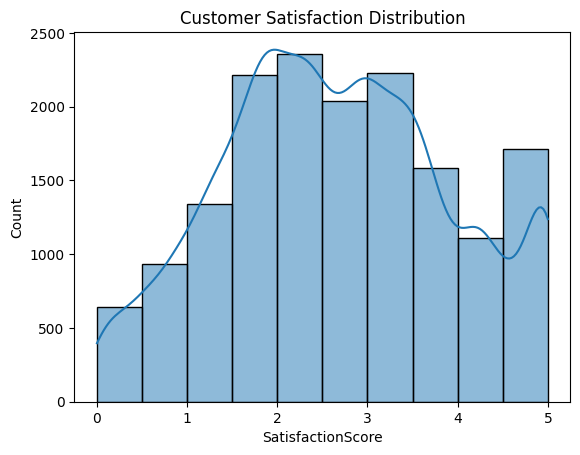

In [16]:
# Overall satisfaction distribution
sns.histplot(df['SatisfactionScore'], bins=10, kde=True)
plt.title("Customer Satisfaction Distribution")
plt.show()

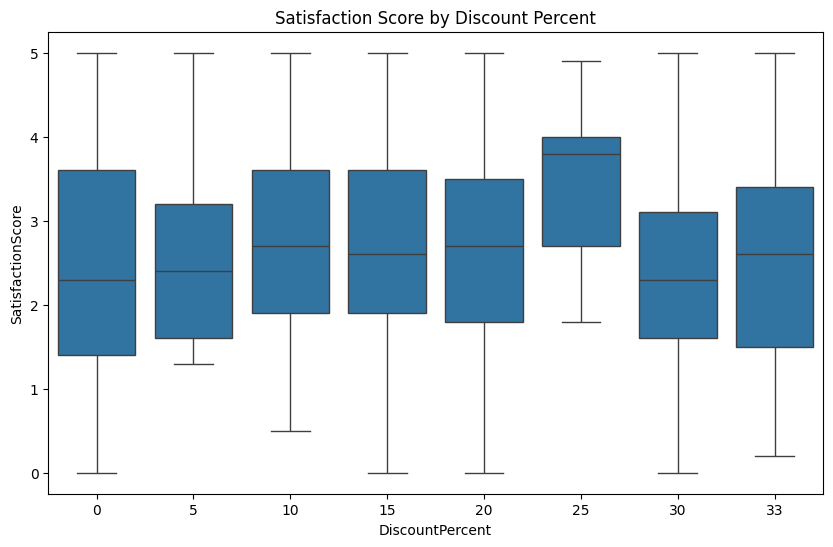

In [17]:
# Satisfaction by Discount
plt.figure(figsize=(10, 6))
sns.boxplot(x='DiscountPercent', y='SatisfactionScore', data=df)
plt.title("Satisfaction Score by Discount Percent")
plt.show()

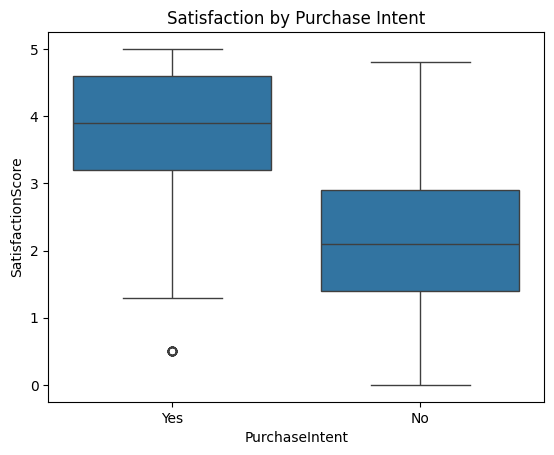

In [18]:
# Satisfaction by Intent
sns.boxplot(x='PurchaseIntent', y='SatisfactionScore', data=df)
plt.title("Satisfaction by Purchase Intent")
plt.show()

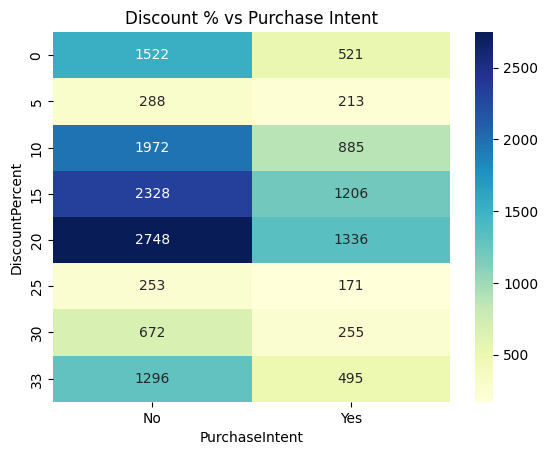

In [19]:
# Discount vs Intent Heatmap
pivot = pd.crosstab(df['DiscountPercent'], df['PurchaseIntent'])
sns.heatmap(pivot, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Discount % vs Purchase Intent")
plt.show()

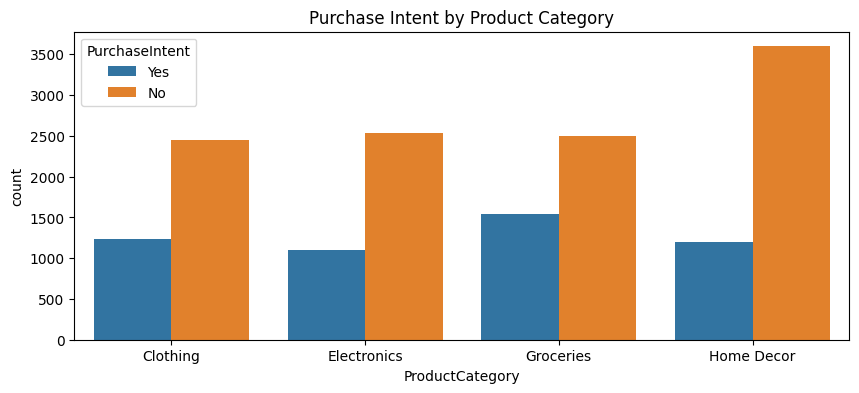

In [20]:
# Category breakdown: Which categories have more 'No' intents?
plt.figure(figsize=(10, 4))
sns.countplot(x='ProductCategory', hue='PurchaseIntent', data=df)
plt.title("Purchase Intent by Product Category")
plt.show()

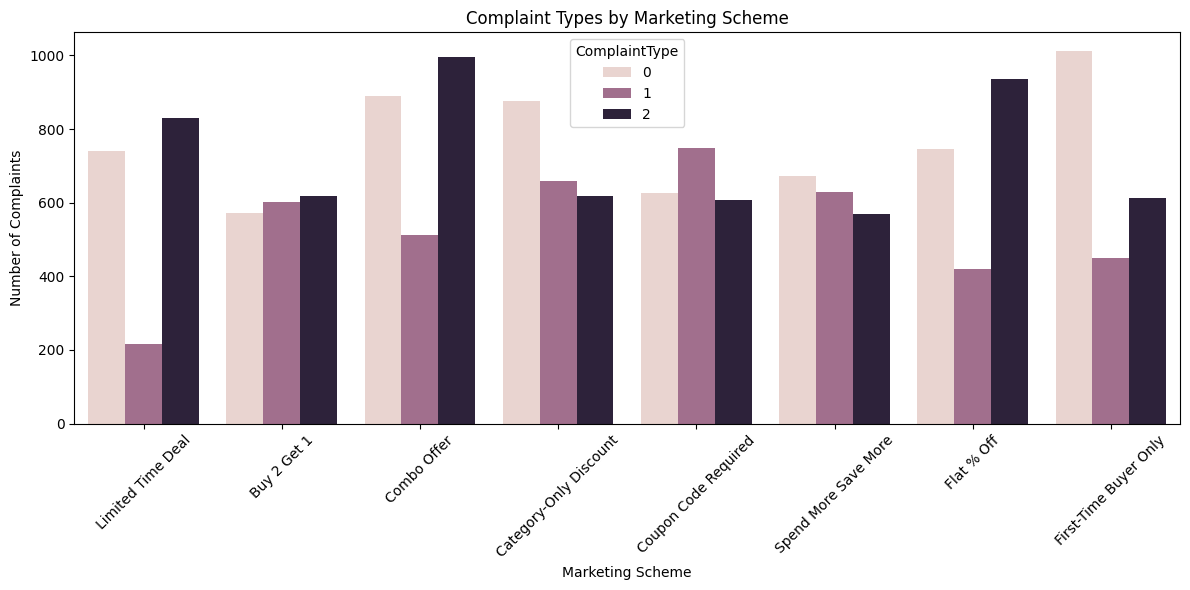

<Figure size 640x480 with 0 Axes>

In [21]:
plt.figure(figsize=(12,6))
sns.countplot(data=df[df["ComplaintType"] != -1], x="MarketingScheme", hue="ComplaintType")
plt.title("Complaint Types by Marketing Scheme")
plt.xlabel("Marketing Scheme")
plt.ylabel("Number of Complaints")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Step 6: Train Classifier

In [22]:
le_scheme = LabelEncoder()
le_cat = LabelEncoder()
le_intent = LabelEncoder()

df['MarketingSchemeEnc'] = le_scheme.fit_transform(df['MarketingScheme'])
df['ProductCategoryEnc'] = le_cat.fit_transform(df['ProductCategory'])
df['PurchaseIntentEnc'] = le_intent.fit_transform(df['PurchaseIntent'])

features = ['MarketingSchemeEnc', 'ProductCategoryEnc', 'DiscountPercent', 'PurchaseIntentEnc']
X = df[features]
y = df['ComplaintType']

safe_samples = pd.DataFrame([
    {
        'MarketingScheme': 'Flat % Off',
        'ProductCategory': 'Clothing',
        'DiscountPercent': 25,
        'PurchaseIntent': 'Yes',
        'ComplaintType': -1
    },
    {
        'MarketingScheme': 'Limited Time Deal',
        'ProductCategory': 'Electronics',
        'DiscountPercent': 20,
        'PurchaseIntent': 'Yes',
        'ComplaintType': -1
    }
])

# Encode safe samples
safe_samples['MarketingSchemeEnc'] = le_scheme.transform(safe_samples['MarketingScheme'])
safe_samples['ProductCategoryEnc'] = le_cat.transform(safe_samples['ProductCategory'])
safe_samples['PurchaseIntentEnc'] = le_intent.transform(safe_samples['PurchaseIntent'])

X_safe = safe_samples[features]
y_safe = safe_samples['ComplaintType']

X_new = pd.concat([X, X_safe], ignore_index=True)
y_new = pd.concat([y, y_safe], ignore_index=True)

X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, stratify=y_new, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1228
           1       0.62      0.58      0.60       847
           2       0.74      0.84      0.79      1158

    accuracy                           0.75      3233
   macro avg       0.74      0.74      0.74      3233
weighted avg       0.76      0.75      0.75      3233

Confusion Matrix:
[[978 133 117]
 [132 494 221]
 [ 21 170 967]]


## Step 7: Smart Recommender

In [23]:
def recommend_scheme(product_category, discount_percent, purchase_intent):
    cat_enc = le_cat.transform([product_category])[0]
    intent_enc = le_intent.transform([purchase_intent])[0]
    scheme_risks = {}

    for scheme in le_scheme.classes_:
        scheme_enc = le_scheme.transform([scheme])[0]
        # features = np.array([[scheme_enc, cat_enc, discount_percent, intent_enc]])
        features = pd.DataFrame([[scheme_enc, cat_enc, discount_percent, intent_enc]],
                        columns=['MarketingSchemeEnc', 'ProductCategoryEnc', 'DiscountPercent', 'PurchaseIntentEnc'])
        pred = model.predict(features)[0]
        scheme_risks[scheme] = pred

    best_schemes = [k for k, v in scheme_risks.items() if v == -1]
    if best_schemes:
        return f"✅ Recommended schemes with lowest complaint risk: {best_schemes}"
    else:
        from collections import Counter
        freq = Counter(scheme_risks.values())
        min_complaint = min(freq, key=freq.get)
        safe_schemes = [k for k, v in scheme_risks.items() if v == min_complaint]
        return f"⚠️ No zero-complaint schemes found. Least risky options: {safe_schemes}"

In [24]:
print(recommend_scheme("Clothing", 25, "Yes"))
print(recommend_scheme("Electronics", 20, "Yes"))

✅ Recommended schemes with lowest complaint risk: ['Flat % Off']
⚠️ No zero-complaint schemes found. Least risky options: ['Combo Offer']


------------

## Step 8: SHAP (model explainability) block

In [25]:
!pip install shap

/tmp/ipython-input-26-4171614212.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sample, plot_type="bar")


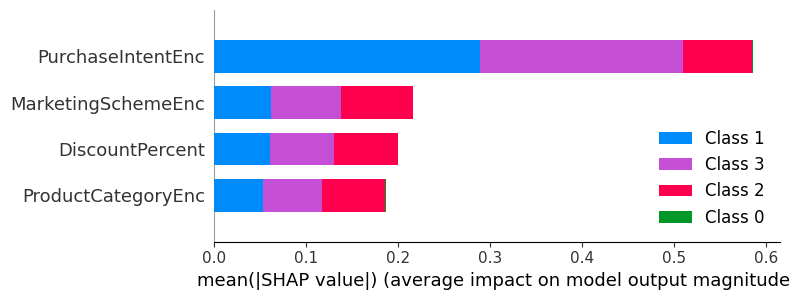

<Figure size 640x480 with 0 Axes>

In [26]:
import shap

X_sample = X_test.copy()
X_sample.columns = ['MarketingSchemeEnc', 'ProductCategoryEnc', 'DiscountPercent', 'PurchaseIntentEnc']

# Create SHAP explainer (TreeExplainer for RandomForest)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# Plot feature importance (summary bar plot)
shap.summary_plot(shap_values, X_sample, plot_type="bar")
plt.savefig("shap_plot.png")

| Class Label | Meaning                                         |
| ----------- | ----------------------------------------------- |
| **-1**      | ✅ No complaint (happy customer)                 |
| **0**       | ❌ Complaint Type 1 (e.g., *“Didn’t need this”*) |
| **1**       | ❌ Complaint Type 2 (e.g., *“Felt tricked”*)     |
| **2**       | ❌ Complaint Type 3 (e.g., *“Useless offer”*)    |


In [27]:
print(model.classes_)

[-1  0  1  2]


---

## 🔍 What the SHAP Plot Tells You (in Real Terms)

### 🎯 1. **What most influences customer complaints**

* `PurchaseIntentEnc` (did the customer really want to buy?) is **by far the most influential**.
* ✅ Business insight: If users didn’t plan to buy, even the best scheme might get complaints — this is crucial for targeted marketing.

---

### 📊 2. **MarketingScheme really matters — but not equally**

* `MarketingSchemeEnc` shows a **moderate effect across multiple complaint types**.
* ✅ Interpretation: Some schemes (like “Buy 2 Get 1”) may confuse customers or seem gimmicky, leading to *specific* complaint types.

---

### 💰 3. **DiscountPercent isn’t always a good thing**

* Larger or oddly small discounts might **trigger suspicion or regret**, especially if paired with pushy schemes.
* ✅ Takeaway: Discount percent should be **tuned based on category and intent**, not just increased blindly.

---

### 🛍️ 4. **Product Category affects complaints modestly**

* Some categories are **riskier** for marketing — e.g., “Home Decor” or “Electronics” may trigger more regret than “Snacks.”
* ✅ Real-world strategy: Be **category-specific** with schemes and messaging.

---

## 🤖 From a Model Perspective

* The SHAP plot confirms that your model isn’t just memorizing — it’s using **intuitive, business-aligned logic**.
* It also shows **which features matter per complaint type** (e.g., Class 1 = “Felt tricked” is heavily influenced by `PurchaseIntentEnc`)

---

## Step 9: Downloads

In [28]:
import pickle
from google.colab import files

# Save model
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save encoders
with open("le_scheme.pkl", "wb") as f:
    pickle.dump(le_scheme, f)

with open("le_cat.pkl", "wb") as f:
    pickle.dump(le_cat, f)

with open("le_intent.pkl", "wb") as f:
    pickle.dump(le_intent, f)

files.download("model.pkl")
files.download("le_scheme.pkl")
files.download("le_cat.pkl")
files.download("le_intent.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>